# LSN Exercise 8

In this numerical exercise we write a **C++ Variational Quantum Monte Carlo code** (`VQMC.h` and `VQMC.cpp`) to obtain a numerical estimation of the ground state energy and wavefunction of a 1D single particle quantum system. We will also exploit the **PIMC/PIGS algorithms** to compare the results of the optimization and to study the system at different temperatures.

In [95]:
# Settings and libraries:

import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

SCALE = 6
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)

# Input functions:

def Read(filename):
    with open(filename) as f:
        vector = [float(i) for i in f.read().splitlines()]
    return vector

# ------------------------------------------------------------

def Read_3_col(filename):
    
    a = []
    b = []
    c = []
    
    with open(filename) as f:
        data = f.read().splitlines()
    
    for i in range(len(data)):
        data[i] = data[i].split()
        a.append(float(data[i][0]))
        b.append(float(data[i][1]))
        c.append(float(data[i][2]))

    return a, b, c

# --------------------------------------------

## 8.1 The variational problem

We consider a quantum particle in a 1D space, confined by a generic potential $V(x)$. if $\hat{H}$ is the hamiltonian operator and $\Psi^{\{ \alpha \}}(x)$ is a *trial wavefucntion* parametrized by a set of real values $\{ \alpha \}$, the expectation value of $\hat{H}$ can be written in the form:

$$ \langle \hat{H} \rangle = \int \frac{|\Psi^{\{ \alpha \}}(x)|^2}{R} E_{loc}(x) \, dx $$

where we $R$ is the normalization of the *pdf* $|\Psi^{\{ \alpha \}}(x)|^2$ and the *local energy* $E_{loc}$ is defined as:

$$ E_{loc}(x) = \frac{{\hat H} \Psi^{\{ \alpha \}}(x)}{\Psi^{\{ \alpha \}}(x)} $$

In $h=m=1$ units and using the schrodinger representation of $\hat{H}$, we can write:

$$ E_{loc}(x) = - \frac{1}{2 \Psi^{\{ \alpha \}}(x)} \dfrac{\partial^2 \Psi^{\{ \alpha \}}(x)}{\partial x^2} + V(x) $$

The aim of the *variational method* is to find the best set of parameters that, for a given $V(x)$ and functional form of $\Psi^{\{ \alpha \}}(x)$, minimizes $\langle \hat{H} \rangle$, giving an *upper bound approximation of the ground state energy*. 

We are going to study a double well confining potential of the form:

$$ V(x) = x^4 - \frac{5}{2} x^2 $$

As suggested by the form of the potential, *the particle will be located predominantly in one of the two wells*; we choose as trial wavefunction a superposition of two gaussians, parametrized by a *center parameter* $\mu$ and a *localization parameter* $\sigma$:

$$ \Psi^{(\mu, \sigma)}(x) = e^{-\frac{(x-\mu)^2}{2\sigma^2}} + e^{-\frac{(x+\mu)^2}{2\sigma^2}} $$

The corrisponding squared modulus and second derivative are:

$$ |\Psi^{(\mu, \sigma)}(x)|^2 = e^{-\frac{(x-\mu)^2}{\sigma^2}} + e^{-\frac{(x+\mu)^2}{\sigma^2}} + 2e^{-\frac{x^2+\mu^2}{\sigma^2}} $$

$$ \dfrac{\partial^2 \Psi^{(\mu, \sigma)}(x)}{\partial x^2} = \left[ \frac{(x-\mu)^2}{\sigma^4} - \frac{1}{\sigma^2} \right] e^{-\frac{(x-\mu)^2}{2\sigma^2}} + \left[ \frac{(x+\mu)^2}{\sigma^4} - \frac{1}{\sigma^2} \right] e^{-\frac{(x+\mu)^2}{2\sigma^2}} $$

The potential is minimum for the symmetrical points $|x| = \frac{\sqrt{5}}{2}$. In what follows we show the trial wavefunction and the potential for $\mu = \frac{\sqrt{5}}{2}$ and $\sigma = 0.3$. 

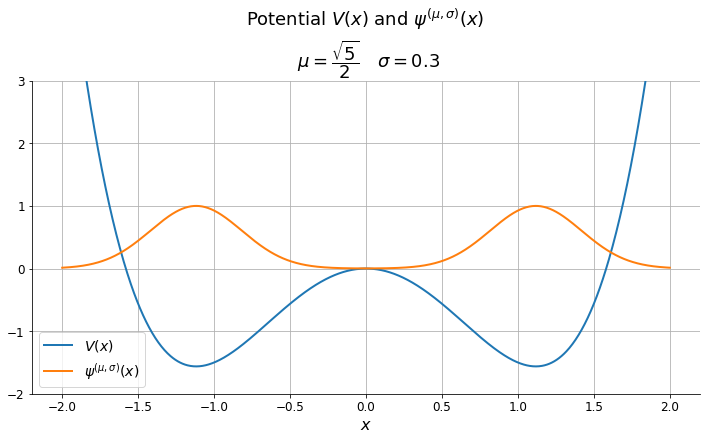

In [96]:
# Potential:

def Vpot(x):
    return (x**2 - 2.5)*x**2

# Wavefunction:

def Psi_T(x, mu, sigma):
    psi = (np.exp(-(x-mu)**2/(2*sigma**2)) + np.exp(-(x+mu)**2/(2*sigma**2)))
    return psi

# Parameters:

mu = np.sqrt(5)/2
sigma = 0.3

X = np.linspace(-2,2,1000)
psi = Psi_T(X, mu, sigma)
pot = Vpot(X)

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.title("Potential $ V(x) $ and $ \psi^{(\mu, \sigma)}(x) $ \n $ \mu = \dfrac{\sqrt{5}}{2} \quad \sigma = 0.3 $")

plt.plot(X, pot, label='$ V(x) $')
plt.plot(X, psi, label='$ \psi^{(\mu, \sigma)}(x) $')
plt.xlabel('$ x $')
plt.ylim(-2,3)
plt.legend()
plt.grid()

## 8.2 VQMC C++ code

We build a `VQMC.h` library, containing the classes:

- `Potential`: the one dimensional potential, together with the virtual method `Eval`, to evaluate the potential at a given point;

- `Psi_Trial`: the trial wavefunction, equipped with the virtual methods `Eval`, `SquareMod` and `D2x`, to evaluate respectively the wavefunction itself, its squared modulus and its second derivative;

The specific potentials and trial wavefunctions are built as new classes inheriting from the upper ones and implementing the virtual methods described. In this specific case we have added the potential and wavefunction described in the previous section, called `Double_Well` and `Psi_Double_Gauss`. For the trial wavefunction we added methods to set and obtain the set of parameters, in this case `mu` and `sigma`.

The class `VQ_MC` contains the object-solver of the problem, built using a `Random` object from the `Random.h` library. *The idea is: one can choose to implement any optimization algorithm, but must always evaluate the expecation value of the hamiltonian*:

$$ \langle \hat{H} \rangle = \int \frac{|\Psi^{\{ \alpha \}}(x)|^2}{R} E_{loc}(x) \, dx $$

*for different sets of parameters $ \{ \alpha \} $*. In order to have the possibility to compute $ \langle \hat{H} \rangle $ many times in the main code, implementing an optimization algorithm, we have built two methods to estimate the expecatation value using *importance sampling*:

- `vector <double> Metropolis_Uniform_Sampling(Psi_Trial* psi, const double start, const double step_size, const int n_step, const int n_eq)`: this method perform the *Metropolis algorithm* using a *uniform transition probability*, sampling from the distribution $|\Psi^{\{ \alpha \}}(x)|^2$. Setting the starting point `start`, the step size `step_size` and the equilibration steps `n_eq`, the output is a vector of size `n_step`, containing the sampled distribution points. The normalization factor $R$ doesn't count anymore, because it cancels in the ratio in the expression of $T(x|x')$;

- `double Energy_Expected_Value(vector <double> sampling, Potential* pot, Psi_Trial* psi)`: this method gives an estimation of the expectation value of the hamiltonian, evaluating the integral as an average over the sampled points contained in `sampling`, obtained for example using `vector <double> Metropolis_Uniform_Sampling`.

## 8.3 The optimization algorithm

In the main code we implement the **simulated annealing algorithm** to search for the optimal parameters $(\mu, \sigma)$ giving the mimimum value of $ \langle \hat{H} \rangle $, an estimation of the ground state energy $E_0$. We consider the set of temperatures $T \in [1,10]$ and, starting from the highest temperature, we slowly "cool down" the system at steps of $0.5$, in order to reach the equilibrium state for which the energy is minimized. For every temperature value we compute $\beta = 1/T$ and we restrict the research step: starting from a step length of $0.25$ for both parameters, we reduce this value by $0.01$ in each block, ensuring ergodicity for higher temperatures and precision for lower ones, for which we assume to be already near the minimum. In each block we perform $10$ equilibration steps and $10$ real steps, exploiting the Metropolis algorithm in the $(\mu, \sigma)$ space: starting from $\mu = \sqrt{5}\, / \, 2$ and $\sigma = 0.3$ and moving with the step sizes desribed, we sample values of $\mu$ and $\sigma$ from uniform distributions centered on the old values, we evaluate energies using the `Metropolis_Uniform_Sampling` and `Energy_Expected_Value` routines (cheking for a reasonable acceptance rate and modyfing the `step_size` if necessary) and we accept moves with a probability proportional to the *Boltzmann weight* : 

$$ exp[-\beta (E_{new} - E_{old})] $$

For every block we print to terminal the optimal values of $\mu$ and $\sigma$ and the estimated minimum of $ \langle \hat{H} \rangle $, together with the acceptance rate. The best values are obtained in the last block, corresponding to the lowest temperature $T=0.5$.

**Running the program we obtained**: $\mu = 0.796433 \sim 0.796$, $\sigma = 0.619904 \sim 0.620$ and $E_0 = -0.443425 \sim -0.443$

In order to get the best estimation of $E_0$ corrisponding to the approximate values obtained, we implement a data-blocking scheme with $100$ blocks, estimating the energy $10$ times in each block, with $10^6$ sampling steps for each evaluation of the intregral: a MC step corrisponds here to a single estimation of the integral. 

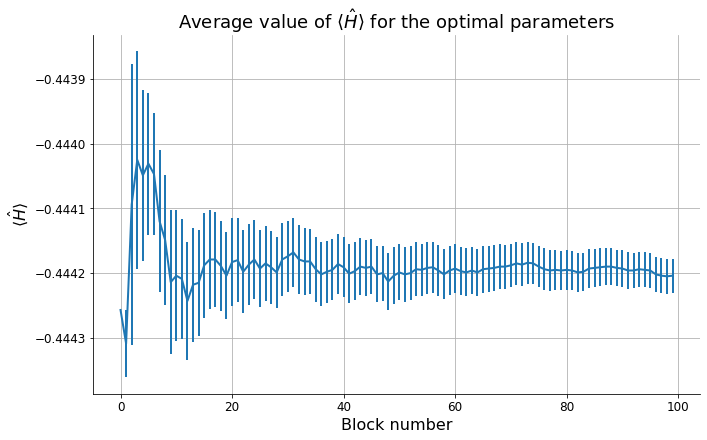

In [97]:
energy = Read("Energy_opt/energy.ave")
energy_err = Read("Energy_opt/energy.error")
N = [i for i in range(len(energy))]

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.errorbar(N, energy, yerr=energy_err)
plt.title("Average value of $ \langle \hat{H} \\rangle $ for the optimal parameters")
plt.xlabel("Block number")
plt.ylabel("$ \langle \hat{H} \\rangle $")
plt.grid()

The convergence is quite sharp, also with a few number of MC steps per block; every single MC step is quite accurate, beacuse we used a huge number of sapmling steps, precede by an equilobration phase. Up to the third decimal point, we conclude that *the best estimation within the frame of optimiztion adopted is $E_{0} = - 0.444$*.

We also show a comparison between:

 - The exact $|\psi_{best}^2(x)|$ for the optimal parameters obtained; 
 - The approximate $|\psi_{best}^2(x)|$ obtained from the numerical solution of the Scrhodinger equation  mapped into a matrix equation;
 - The sampled configurations using the Metropolis algorithm inside the code, looking at $|\psi_{best}^2(x)|$ as a one dimensional pdf;
 
To compare the *normalized* $|\psi_{best}^2(x)|$, we extract the normalization factor:

$$ R = 2 \sqrt{\pi} \sigma \, \left( 1 + e^{- \frac{\mu^2}{\sigma^2}} \right) $$

and we normalize the histogram of the sampled configurations. The following plot shows the nice agreement between the analytical and sampled $|\psi_{best}^2(x)|$, together with the matrix approximate solution.

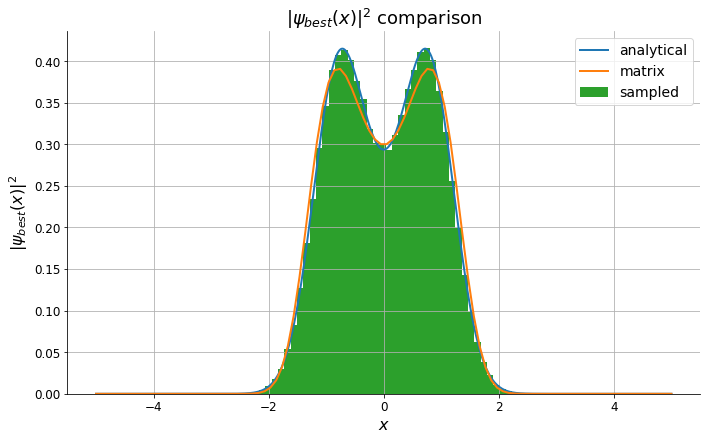

In [98]:
# --- Parameters --- #

a = 10
mu = 0.796
sigma = 0.620

# --- Potential --- #

def Vpot(x):
    return (x**2 - 2.5)*x**2

# --- Analytical curve --- #

def Psi_Square(x, mu, sigma):
    psi = (np.exp(-(x-mu)**2/(2*sigma**2)) + np.exp(-(x+mu)**2/(2*sigma**2)))
    return psi*psi

# Normalization factor
Norm = 2*np.sqrt(np.pi)*sigma*(1 + np.exp(-(mu/sigma)**2))

X = np.linspace(-a/2,a/2,1000)
psi_an = Psi_Square(X, mu, sigma)
psi_an /= Norm

# -----------------------------------------------------------------------------

# --- Matrix equation approximate solution --- #

# Reduced units and number of iterations
hbar = 1
m = 1
N = 100

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0]

# Potential 
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E, psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)
psi_mat = (psi[0])**2

# ----------------------------------------------------------------------------------

# --- Sampled distribution --- # 

psi_samp = Read("Psi2/psi2.hist")
nbins = 50

# ------------------------------

# --- Plotting --- #

plt.figure(figsize=FIG_SIZE, constrained_layout=True)
plt.plot(X, psi_an, label='analytical')                   # Analytical curve for the best parameters
plt.plot(x, psi_mat, label='matrix')                      # Matrix equation solution
plt.hist(psi_samp, nbins, density=True, label='sampled')  # Sampled distribution from Metropolis algorithm
plt.title("$ |\psi_{best}(x)|^2 $ comparison")
plt.xlabel("$ x $")
plt.ylabel("$ |\psi_{best}(x)|^2 $")
plt.legend()
plt.grid()

## 8.4 PIGS and PIMC simulations

In this section we make use of the **PIGS** algorithm to project two different wavefunctions via imaginary time evolution, varying the *propagation time* and making a comparison with the best ground state wavefunction estimated via the variational method. Finally, using the **PIMC** algorithm, we study how the approximate ground state changes with temperature.

Fisrt we project a **costant trial wavefunction**, reducing the imaginary propagation time from $\tau=8.0$ to $\tau=0.1$.

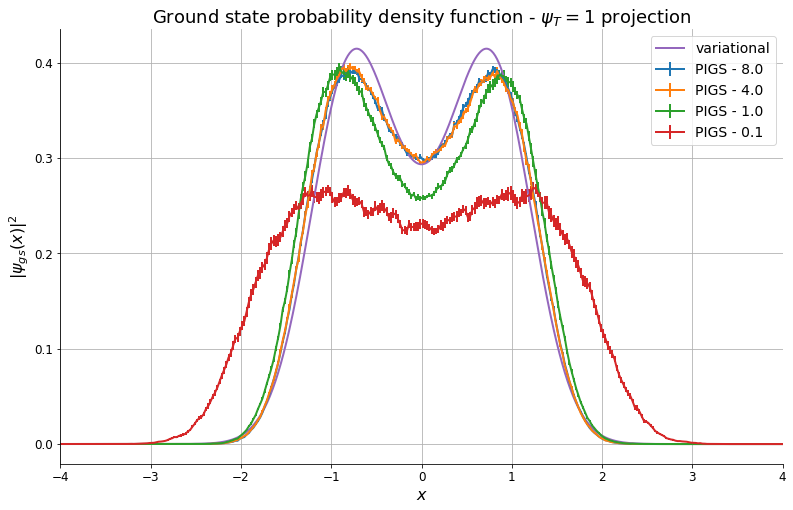

In [121]:
x, psi1, psi1_err = Read_3_col("QMC_1D/Psi_gs/probability_const_8.dat")
x, psi2, psi2_err = Read_3_col("QMC_1D/Psi_gs/probability_const_4.dat")
x, psi3, psi3_err = Read_3_col("QMC_1D/Psi_gs/probability_const_1.dat")
x, psi4, psi4_err = Read_3_col("QMC_1D/Psi_gs/probability_const_01.dat")

SCALE = 8
FIG_SIZE = (SCALE*0.5*(1+np.sqrt(5)),SCALE)
plt.figure(figsize=FIG_SIZE)
plt.errorbar(x, psi1, yerr=psi1_err, label='PIGS - 8.0')      # PIGS - time = 8.0
plt.errorbar(x, psi2, yerr=psi2_err, label='PIGS - 4.0')      # PIGS - time = 4.0
plt.errorbar(x, psi3, yerr=psi3_err, label='PIGS - 1.0')      # PIGS - time = 1.0
plt.errorbar(x, psi4, yerr=psi4_err, label='PIGS - 0.1')      # PIGS - time = 0.1
plt.plot(X, psi_an, label='variational')                      # Analytical curve for the best parameters
plt.xlim(-4,4)
plt.title("Ground state probability density function - $\psi_T = 1$ projection")
plt.xlabel("$x$")
plt.ylabel("$ |\psi_{gs}(x)|^2 $")
plt.legend()
plt.grid()

The projected ground state is stable for $\tau=8.0$ and $\tau=4.0$ and slightly different from the approximate variational solution. Using $\tau=1.0$ the ground state pdf start collapsing, and for $\tau=0.1$ we obtain a delocalized ground state: it's possible to reduce the propagation time only till $\tau=1.0$.

As second trial wavefucntion we use $\Psi^{(\mu, \sigma)}(x)$ for the optimal values of $\mu$ and $\sigma$ obtained with the variational method. In this case the propagation time can be reduced up to $\tau=0.1$ without significant changings in the projected ground state, as shown in the following plots: this is due to the fact that the starting state is already in proximity of the true ground state, if we are confident of our previous optimization.

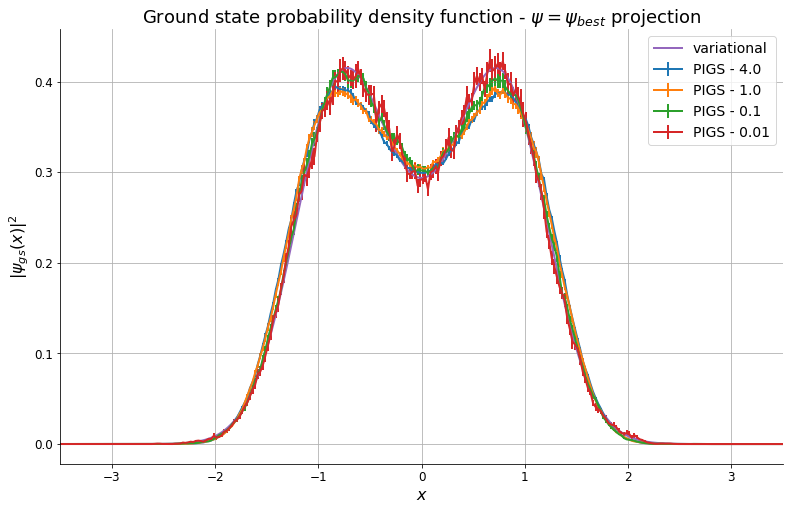

In [120]:
x, psi1, psi1_err = Read_3_col("QMC_1D/Psi_gs/probability_4.dat")
x, psi2, psi2_err = Read_3_col("QMC_1D/Psi_gs/probability_1.dat")
x, psi3, psi3_err = Read_3_col("QMC_1D/Psi_gs/probability_01.dat")
x, psi4, psi4_err = Read_3_col("QMC_1D/Psi_gs/probability_001.dat")


plt.figure(figsize=FIG_SIZE)
plt.errorbar(x, psi1, yerr=psi1_err, label='PIGS - 4.0')      # PIGS - time = 4.0
plt.errorbar(x, psi2, yerr=psi2_err, label='PIGS - 1.0')      # PIGS - time = 1.0
plt.errorbar(x, psi3, yerr=psi3_err, label='PIGS - 0.1')      # PIGS - time = 0.1
plt.errorbar(x, psi4, yerr=psi4_err, label='PIGS - 0.01')     # PIGS - time = 0.01
plt.plot(X, psi_an, label='variational')                      # Analytical curve for the best parameters
plt.xlim(-3.5,3.5)
plt.title("Ground state probability density function - $\psi = \psi_{best}$ projection")
plt.xlabel("$x$")
plt.ylabel("$ |\psi_{gs}(x)|^2 $")
plt.legend()
plt.grid()

Using the optimized trial wavefunction and the reduced propagation time $\tau=0.1$, we study how the sampled configurations change increasing the temperature from $T=0$ up to $T=220$, following the *route from the quantum regime to the classical limit*, where the quantum degrees of freedom are unimportant.

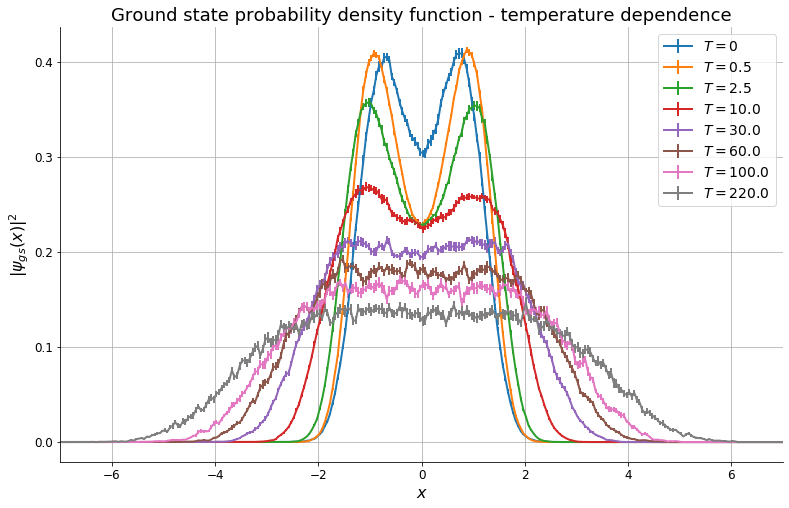

In [129]:
x, psi1, psi1_err = Read_3_col("QMC_1D/Temp/probability_0.dat")
x, psi2, psi2_err = Read_3_col("QMC_1D/Temp/probability_05.dat")
x, psi3, psi3_err = Read_3_col("QMC_1D/Temp/probability_25.dat")
x, psi4, psi4_err = Read_3_col("QMC_1D/Temp/probability_10.dat")
x, psi5, psi5_err = Read_3_col("QMC_1D/Temp/probability_30.dat")
x, psi6, psi6_err = Read_3_col("QMC_1D/Temp/probability_60.dat")
x, psi7, psi7_err = Read_3_col("QMC_1D/Temp/probability_100.dat")
x, psi8, psi8_err = Read_3_col("QMC_1D/Temp/probability_220.dat")

plt.figure(figsize=FIG_SIZE)
plt.errorbar(x, psi1, yerr=psi1_err, label='$T=0$')        # PIMC - temp = 0
plt.errorbar(x, psi2, yerr=psi2_err, label='$T=0.5$')      # PIMC - temp = 0.5
plt.errorbar(x, psi3, yerr=psi3_err, label='$T=2.5$')      # PIMC - temp = 2.5
plt.errorbar(x, psi4, yerr=psi4_err, label='$T=10.0$')     # PIMC - temp = 10.0
plt.errorbar(x, psi5, yerr=psi5_err, label='$T=30.0$')     # PIMC - temp = 30.0
plt.errorbar(x, psi6, yerr=psi6_err, label='$T=60.0$')     # PIMC - temp = 60.0
plt.errorbar(x, psi7, yerr=psi7_err, label='$T=100.0$')    # PIMC - temp = 100.0
plt.errorbar(x, psi8, yerr=psi8_err, label='$T=220.0$')    # PIMC - temp = 220.0
plt.xlim(-7.0,7.0)
plt.title("Ground state probability density function - temperature dependence")
plt.xlabel("$x$")
plt.ylabel("$ |\psi_{gs}(x)|^2 $")
plt.legend()
plt.grid()

The picture above shows the *gradual disintegration of the wavefunction*: at high temperatures ther's no distinction between the two wells and every configuration becomes equally likely, except for the positions too far from the center of the potential, where the effect of repulsion is strong.     